In [1]:
!pip install gymnasium[all] matplotlib tqdm pandas --quiet


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.4/374.4 kB 20.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.1/62.1 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 25.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.2/58.2 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 76.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.9/16.9 MB 56.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 74.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 72.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 42.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.6 MB/s eta 0:00:00
   ━━━━━

In [2]:
import gymnasium as gym
import numpy as np
import random
from collections import defaultdict
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import pandas as pd


In [3]:
env = gym.make("FrozenLake-v1", map_name="4x4", is_slippery=False)


In [4]:
def epsilon_greedy(Q, state, n_actions, epsilon):
    if random.random() < epsilon:
        return random.randint(0, n_actions - 1)
    else:
        return np.argmax(Q[state])


In [5]:
def td0_q_learning(env, episodes=100000, alpha=0.1, gamma=0.99, epsilon=1.0, min_epsilon=0.1, decay_rate=0.999):
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    rewards = []

    for ep in tqdm(range(episodes)):
        state, _ = env.reset()
        done = False
        ep_reward = 0

        while not done:
            action = epsilon_greedy(Q, state, env.action_space.n, epsilon)
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated

            best_next = np.max(Q[next_state])
            Q[state][action] += alpha * (reward + gamma * best_next - Q[state][action])

            state = next_state
            ep_reward += reward

        epsilon = max(min_epsilon, epsilon * decay_rate)
        rewards.append(ep_reward)

    return Q, rewards


In [6]:
def td_lambda_sarsa(env, episodes=100000, alpha=0.1, gamma=0.99, epsilon=1.0, min_epsilon=0.1, decay_rate=0.999, lam=0.8):
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    rewards = []

    for ep in tqdm(range(episodes)):
        state, _ = env.reset()
        action = epsilon_greedy(Q, state, env.action_space.n, epsilon)
        done = False
        eligibility = defaultdict(lambda: np.zeros(env.action_space.n))
        ep_reward = 0

        while not done:
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            next_action = epsilon_greedy(Q, next_state, env.action_space.n, epsilon)

            td_error = reward + gamma * Q[next_state][next_action] - Q[state][action]
            eligibility[state][action] += 1

            for s in Q.keys():
                for a in range(env.action_space.n):
                    Q[s][a] += alpha * td_error * eligibility[s][a]
                    eligibility[s][a] *= gamma * lam

            state = next_state
            action = next_action
            ep_reward += reward

        epsilon = max(min_epsilon, epsilon * decay_rate)
        rewards.append(ep_reward)

    return Q, rewards


In [7]:
def td_lambda_q_learning(env, episodes=100000, alpha=0.1, gamma=0.99, epsilon=1.0, min_epsilon=0.1, decay_rate=0.999, lam=0.8):
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    rewards = []

    for ep in tqdm(range(episodes)):
        state, _ = env.reset()
        done = False
        eligibility = defaultdict(lambda: np.zeros(env.action_space.n))
        ep_reward = 0

        while not done:
            action = epsilon_greedy(Q, state, env.action_space.n, epsilon)
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated

            next_best = np.argmax(Q[next_state])
            td_error = reward + gamma * Q[next_state][next_best] - Q[state][action]
            eligibility[state][action] += 1

            for s in Q.keys():
                for a in range(env.action_space.n):
                    Q[s][a] += alpha * td_error * eligibility[s][a]
                    eligibility[s][a] *= gamma * lam

            state = next_state
            ep_reward += reward

        epsilon = max(min_epsilon, epsilon * decay_rate)
        rewards.append(ep_reward)

    return Q, rewards


In [8]:
def ddqn(env, episodes=100000, alpha=0.1, gamma=0.99, epsilon=1.0, min_epsilon=0.1, decay_rate=0.999, target_update=100):
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    Q_target = defaultdict(lambda: np.zeros(env.action_space.n))
    rewards = []

    for ep in tqdm(range(episodes)):
        state, _ = env.reset()
        done = False
        ep_reward = 0

        while not done:
            action = epsilon_greedy(Q, state, env.action_space.n, epsilon)
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated

            next_best = np.argmax(Q[next_state])
            Q[state][action] += alpha * (reward + gamma * Q_target[next_state][next_best] - Q[state][action])

            state = next_state
            ep_reward += reward

        if ep % target_update == 0:
            Q_target = defaultdict(lambda: np.zeros(env.action_space.n), {k: v.copy() for k, v in Q.items()})

        epsilon = max(min_epsilon, epsilon * decay_rate)
        rewards.append(ep_reward)

    return Q, rewards


In [9]:
Q_td0, rewards_td0 = td0_q_learning(env)
Q_sarsa, rewards_sarsa = td_lambda_sarsa(env)
Q_q_lambda, rewards_q_lambda = td_lambda_q_learning(env)
Q_ddqn, rewards_ddqn = ddqn(env)


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

/tmp/ipython-input-7-191961867.py:22: RuntimeWarning: overflow encountered in scalar add
  Q[s][a] += alpha * td_error * eligibility[s][a]
/tmp/ipython-input-7-191961867.py:22: RuntimeWarning: invalid value encountered in scalar multiply
  Q[s][a] += alpha * td_error * eligibility[s][a]


  0%|          | 0/100000 [00:00<?, ?it/s]

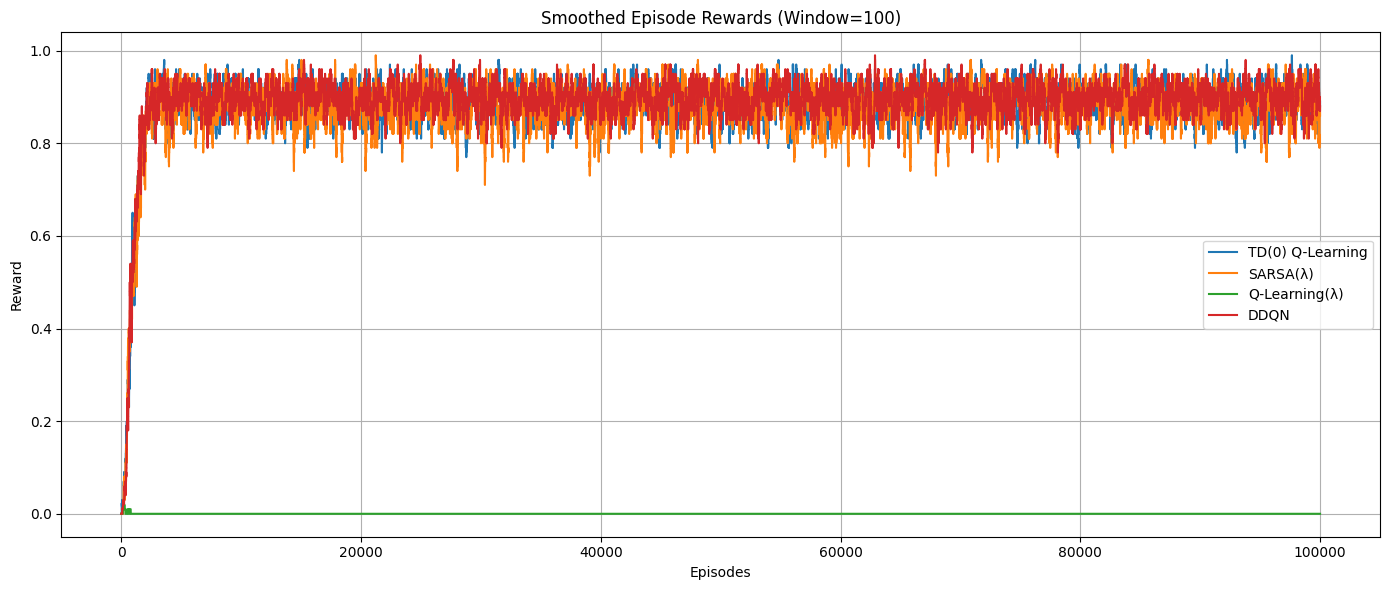

📈 Sample rewards from each agent:
TD(0) Q-Learning: max=1.0, min=0.0, mean=0.885
SARSA(λ): max=1.0, min=0.0, mean=0.875
Q-Learning(λ): max=1.0, min=0.0, mean=0.000
DDQN: max=1.0, min=0.0, mean=0.888


In [10]:
def moving_avg(data, window=100):
    return pd.Series(data).rolling(window, min_periods=1).mean()

results = {
    'TD(0) Q-Learning': rewards_td0,
    'SARSA(λ)': rewards_sarsa,
    'Q-Learning(λ)': rewards_q_lambda,
    'DDQN': rewards_ddqn
}

df_results = pd.DataFrame({k: pd.Series(v) for k, v in results.items()})

plt.figure(figsize=(14, 6))
for column in df_results.columns:
    plt.plot(moving_avg(df_results[column]), label=column)
plt.title("Smoothed Episode Rewards (Window=100)")
plt.xlabel("Episodes")
plt.ylabel("Reward")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

print("📈 Sample rewards from each agent:")
for name, rewards in results.items():
    print(f"{name}: max={max(rewards)}, min={min(rewards)}, mean={np.mean(rewards):.3f}")
